In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [6]:
dataset = pd.read_csv('network_backup_dataset.csv')

In [7]:
def getX_Y_from_dataset(dataset):
    Y = (dataset['Size of Backup (GB)'].as_matrix())
    X = dataset.drop(['Size of Backup (GB)'],axis=1)
    return X,Y

In [8]:
def one_hot_encode(dataset):
    le = preprocessing.LabelEncoder()
    dataset_cat = dataset.select_dtypes(include=[object])
    dataset_cat.head()
    dataset_cat = dataset_cat.apply(le.fit_transform)
    oh_enc = preprocessing.OneHotEncoder()
    oh_enc.fit(dataset_cat)
    onehotlabels = oh_enc.transform(dataset_cat)
    cat_array = onehotlabels.toarray()
    dataset_no_cat = dataset.select_dtypes(exclude=[object])
    non_cat_array = dataset_no_cat.as_matrix()
    return np.concatenate((non_cat_array,cat_array),axis = 1)
    

In [9]:
def perform_10fold(X,y,regressor):
    kf = KFold(n_splits=10,random_state = 0)
    i = 1
    bestModel = None
    tr_e = 0
    ts_e = 0
    min_ts_e = 10
    for train_index, test_index in kf.split(X):
        #print("Fold : ",i)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor.fit(X_train,y_train)
        train_preds = regressor.predict(X_train)
        test_preds = regressor.predict(X_test)
        test_error = mean_squared_error(y_test,test_preds)
        tr_e += mean_squared_error(y_train,train_preds)
        ts_e += test_error
        if(test_error<min_ts_e):
            min_ts_e = test_error
            bestModel = regressor
        i = i+1
    return np.sqrt(tr_e/10),np.sqrt(ts_e/10), bestModel

In [10]:
X,Y= getX_Y_from_dataset(dataset)

In [11]:
X =one_hot_encode(X)

In [12]:
def analyse_nn_regressor(layers,max_layer_size,interval):
    train_map = defaultdict(list)
    test_map = defaultdict(list)
    for activation_ in ['identity', 'logistic', 'tanh', 'relu']:
        for hidden_size in range(1,max_layer_size,interval):
            print('size_',hidden_size,'activation function:',activation_)
            mlp_reg = MLPRegressor(hidden_layer_sizes=tuple([hidden_size]*layers),activation=activation_,random_state=1)
            train_rmses,test_rmses,m=perform_10fold(X,Y,mlp_reg)
            print(train_rmses,test_rmses)
            train_map[activation_].append(train_rmses)
            test_map[activation_].append(test_rmses)
    for algo in test_map:
        plt.plot(range(1,max_layer_size,interval),test_map[algo], label = algo, marker='.',markersize=4)
    plt.title('Neural Network Regression Performance | size ='+str(tuple([hidden_size]*layers)))
    plt.legend()
    plt.show()
            

size_ 1 activation function: identity
0.072005532912 0.072146242817
size_ 3 activation function: identity
0.0836151658933 0.0840780598145
size_ 5 activation function: identity
0.0719051483461 0.0720391530713
size_ 7 activation function: identity
0.0715887250206 0.0717712064863
size_ 9 activation function: identity
0.0719757965208 0.0718618720666
size_ 11 activation function: identity
0.0716516431844 0.0717921437315
size_ 13 activation function: identity
0.0722879651392 0.0723530350844
size_ 15 activation function: identity
0.0719895276256 0.0720522900203
size_ 17 activation function: identity
0.0748533223 0.0754651816754
size_ 19 activation function: identity
0.071526006302 0.0716279025241
size_ 1 activation function: logistic
0.102868116082 0.102893001579
size_ 3 activation function: logistic
0.103898395113 0.103899446465
size_ 5 activation function: logistic
0.101584804165 0.101593964124
size_ 7 activation function: logistic
0.0509370062533 0.0513797633866
size_ 9 activation function

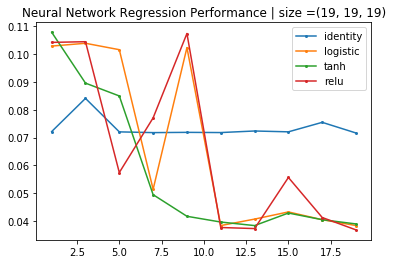

In [9]:
analyse_nn_regressor(3,20,2)

## KNN

In [14]:
errors = []
for neighbors in range(1,20):
    print("Neighbors:",neighbors)
    knn_model = KNeighborsRegressor(neighbors)
    tr,ts,m = perform_10fold(X,Y,knn_model)
    errors.append(ts)
    
    

Neighbors: 1
Neighbors: 2
Neighbors: 3
Neighbors: 4
Neighbors: 5
Neighbors: 6
Neighbors: 7
Neighbors: 8
Neighbors: 9
Neighbors: 10
Neighbors: 11
Neighbors: 12
Neighbors: 13
Neighbors: 14
Neighbors: 15
Neighbors: 16
Neighbors: 17
Neighbors: 18
Neighbors: 19


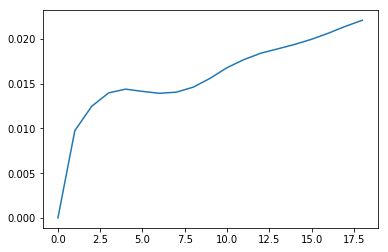

In [15]:
plt.plot(errors)
plt.show()

In [20]:
workflow_datasets=[dataset.loc[dataset['Work-Flow-ID'] == x] for x in  set(list(dataset['Work-Flow-ID'].values))]
workflow_datasets_xy = [getX_Y_from_dataset(d) for d in workflow_datasets] 
workflow_datasets_xy_oh = [(one_hot_encode(x[0]),x[1]) for x in workflow_datasets_xy]